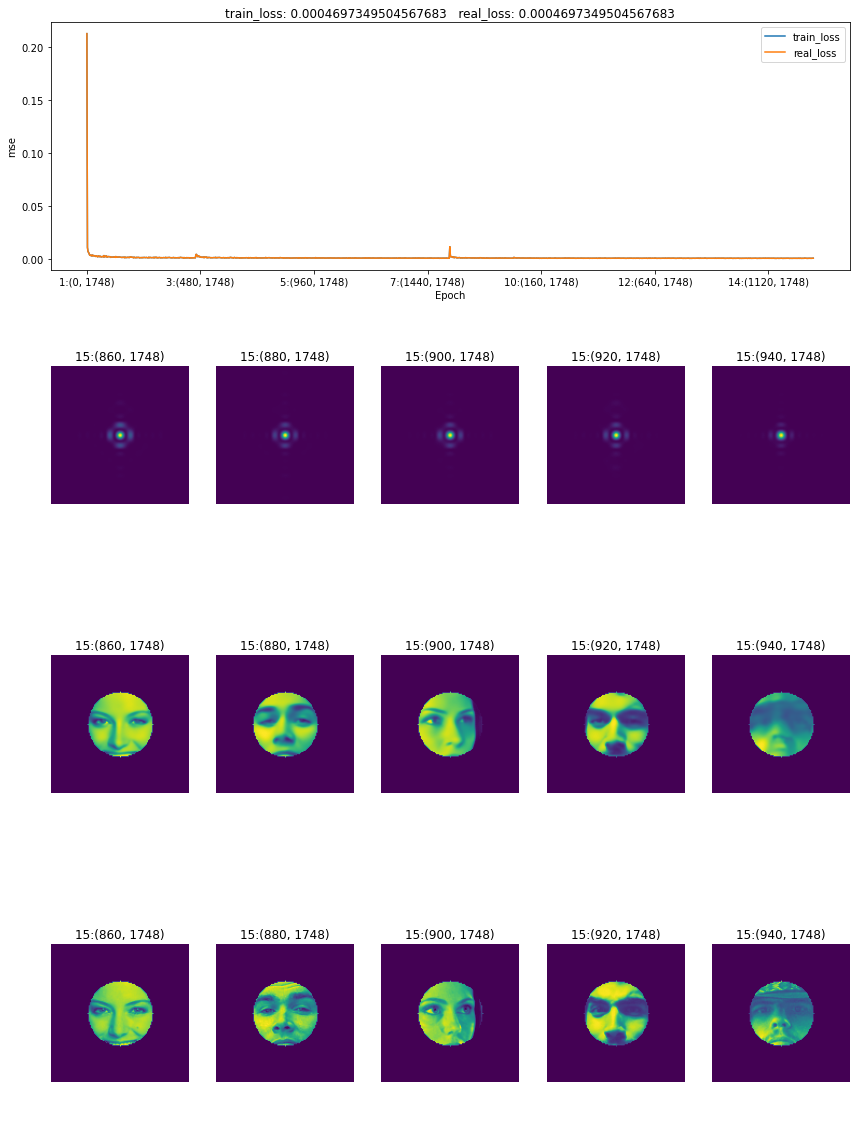

train:epoch=>14, step=>942/1748, loss = 0.000312, real = 0.000312


In [1]:
import time

import hiddenlayer as hl
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torchvision
from PIL import Image
from torch import nn
from torch.utils.data import random_split

import generate_datasets
# from generate_datasets import mnist_dataset
from generate_datasets import face_dataset
from model import model
from model.unet import UNet
torch.cuda.empty_cache()
# Data parameters
data_folder = './data/train_CelebA_128/'  # folder with JSON data files
dataset = 'CelebA'
model_name = 'Unet'
train_data_name = 'train_' + dataset #+ '_128'
test_data_name = 'test_' + dataset# + '_128'
crop_size = 128          # crop size of target HR images
fourier_size = 300
scaling_factor = 1       # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor
# pad_factor = 2           # this version needs to set pad_factor = 2



# Learning parameters
checkpoint = None  # path to model (SRGAN) checkpoint, None if none
batch_size = 16    # batch size
start_epoch = 0    # start at this epoch

workers = 0        # number of workers for loading data in the DataLoader
betas=(0.8, 0.999)    # the coefficient to weight the adversarial loss in the perceptual loss
print_freq = 20  # print training status once every __ batches
lr = 1e-3         # learning rate
epochs = 50

# Default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

model_save_path = './models/checkpoint/checkpoint_%s_%s_v2.pth.tar' % (model_name, dataset)


# """
# Training.
# """
# global start_epoch, epoch, checkpoint, srresnet_checkpoint

# Initialize model or load checkpoint
net = UNet(crop_size, crop_size, batch_size).cuda()



# Initialize generator's optimizer
# optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, net.parameters()),lr=lr)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.8, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                        mode='min',
                                                        factor=0.5,
                                                        patience=3625*3,
                                                        cooldown=3625,
                                                        verbose=True)
# Loss functions
criterion = nn.MSELoss()

# Custom dataloaders
train_dataset = face_dataset(data_folder,crop_size,fourier_size)
    
# train_dataset, test_dataset = random_split(
#         dataset = custom_dataset,
#         lengths = [int(len(custom_dataset)*0.9),len(custom_dataset) - int(len(custom_dataset)*0.9)],
#         generator = torch.manual_seed(0))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=workers,
                                                pin_memory=False, drop_last=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=workers,
#                                                 pin_memory=False, drop_last=True)
    
# One epoch's training
print("start train")


# 3 construct loss and optimizer

best_loss = float('inf')

# 记录训练过程的指标 A History object to store metrics
history = hl.History()
# 使用canvas进行可视化 A Canvas object to draw the metrics
canvas = hl.Canvas()
canvasloss = hl.Canvas()


# Total number of epochs to train for
for epoch in range(start_epoch, epochs):
    # print(epoch)
    for i, (I, P_real) in enumerate(train_loader):
    # At the halfway point, reduce learning rate to a tenth
        I = I.to(device=device, dtype=torch.float32)
        P_real = P_real.to(device=device, dtype=torch.float32)
        
        
        # training cycle

        # 训练模式
        net.train()
        optimizer.zero_grad()


        # __, P0 = back(I, P1)
        # 使用网络参数，输出预测结果
        P_pred = net(I)
        # I1, __ = H(torch.ones_like(P_pred), P_pred)

            

        # loss = loss1 + loss2 / (loss2 / loss1).detach()
        loss = criterion(P_pred.to(torch.float32), P_real.to(torch.float32))        
        valid = criterion(P_pred.to(torch.float32), P_real.to(torch.float32))


        # 保存loss值最小的网络参数
            # Save checkpoint
        if loss < best_loss:
            best_loss = loss
            torch.save(net.state_dict(),  model_save_path)
        print('best_loss = %lf' % (best_loss))


        # 更新参数
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        
        if i % print_freq == 0:
            history.log((epoch + 1, (i, len(train_loader))),
                        train_loss=loss,
                        real_loss=valid,
                        net_in=I.detach().cpu()[0, 0, :, :].numpy(),
                        out=P_pred.detach().cpu()[0, 0, :, :].numpy(),
                        real=P_real.detach().cpu()[0, 0, :, :].numpy())
        # Print progress status
            history.progress()
        # Less occasionally, save a snapshot of the graphs
        # Plot the two metrics in one graph
        

        with canvas:
            canvas.draw_plot([history["train_loss"], history["real_loss"]], ylabel='mse')
            canvas.draw_image(history["net_in"])
            canvas.draw_image(history["out"])
            canvas.draw_image(history["real"])                
        time.sleep(0.1)

        print('train:epoch=>%d, step=>%d/%d, loss = %f, real = %f' % (epoch - start_epoch,
                                                                    i,
                                                                    len(train_loader),
                                                                    loss.item(),
                                                                    valid.item())) # redirect 重定向
            

    canvasloss.draw_plot([history["train_loss"], history["real_loss"]], ylabel='mse')
    # Save the canvas
    canvasloss.save('./evaluation/pretrain_progress_faceface1.png')
    canvas.save('./evaluation/pretrain_last_mni_faceface1.png')
    history.summary()
    history.save('./evaluation/history/pretrain_faceface1.pk1')
    canvas.save('./evaluation/training_progress_faceface1.png')